NeuroLang Datalog Example based on the FMA Ontology and Neurosynth
=====================================================================


Uploading the FMA Ontology into NeuroLang and executing some simple queries.

For more information about FMA Ontology, visit:
https://bioportal.bioontology.org/ontologies/FMA

Link to download RadLex ontology: http://radlex.org/

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from neurosynth.analysis import meta
import nibabel as nib
import nilearn as nil
import numpy as np
from neurolang.frontend.ontolgy_utils import OntologyHandler
from neurolang import frontend as fe
from nilearn import plotting
import neurolang.region_solver

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/data_manipulation.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [3]:
#paths = ['./fma.owl', './RadLex.owl']
#namespaces = ['http://purl.org/sig/ont/fma/', 'http://radlex.org/RID/']
#paths = './fma.owl'
#namespaces = 'http://purl.org/sig/ont/fma/'
neurolang.region_solver.REFINE_OVERLAPPING = False
paths = ['./neurofma_fma3.0.owl']
namespaces = ['http://sig.biostr.washington.edu/fma3.0']
onto = OntologyHandler(paths, namespaces)
nl = fe.NeurolangDL()
nl = onto.load_ontology(nl, destriuex_relations=True)

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


In [4]:
@nl.add_symbol
def region_volume(region: fe.ExplicitVBR) -> float:
    volume = (
        len(region.voxels) *
        float(np.product(np.abs(np.linalg.eigvals(region.affine[:-1, :-1]))))
    )
    return volume    

In [5]:
from neurolang.regions import Region, region_union as region_union_
import typing 

@nl.add_symbol
def region_union(
    region_set: typing.AbstractSet[Region]
) -> Region:
    return region_union_(region_set)


In [6]:
from neurolang.regions import region_intersection as region_intersection_, ExplicitVBR
@nl.add_symbol
def region_intersection(
    region_left: Region, region_right: Region
) -> Region:
    
    r_ijk = region_right.to_ijk(region_left.affine)
    region_right = ExplicitVBR(r_ijk, region_left.affine, image_dim=region_left.image_dim)
    temp = region_intersection_((region_left, region_right))
    if temp is None:
        return ExplicitVBR([[0,0,0]], region_left.affine)
    return temp



After load the ontology, we can try a simple query to test that everything is working well. 

We can retrieve the parents of the 'Lobe of cerebral hemisphere' entity:

In [30]:
with nl.environment as e:
    res = nl.query(
        (e.y1,),
        e.rdf_schema_label(e.x1, 'Lobe of cerebral hemisphere') &
        e.rdf_schema_label(e.x2, e.y1) &
        e.rdf_schema_subClassOf(e.x1, e.x2)
    )
for r in res:
    print(r[0])

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


Segment of cerebral hemisphere
Segment of telencephalon
Segment of forebrain
Segment of brain
Segment of neuraxis
Organ segment
Organ region
Cardinal organ part
Anatomical structure
Material anatomical entity
Physical anatomical entity
Anatomical entity template
Anatomical entity
Standard FMA class


We can retrieve all the subcategories that has 'Lobe of cerebral hemisphere' as a parent:

In [29]:
with nl.environment as e:
    res = nl.query(
        (e.y1,),
        e.rdf_schema_label(e.x1, 'Lobe of cerebral hemisphere') &
        e.rdf_schema_label(e.x2, e.y1) &
        e.rdf_schema_subClassOf(e.x2, e.x1)
    )
for r in res:
    print(r[0])

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


Limbic lobe
Frontal lobe
Temporal lobe
Parietal lobe
Occipital lobe
Insula
Right temporal lobe
Left frontal lobe
Right insula
Left temporal lobe
Left parietal lobe
Left limbic lobe
Right limbic lobe
Left insula
Right occipital lobe
Left occipital lobe
Right parietal lobe
Right frontal lobe


Or, all the regional parts (the property need to be defined in the ontology) of the 'Right frontal lobe'

In [21]:
with nl.environment as e:

    res = nl.query(
        (e.y1,),
        e.rdf_schema_label(e.x1, 'Right frontal lobe') &
        e['fma3.0_regional_part_of'](e.x2, e.x1) &
        e.rdf_schema_label(e.x2, e.y1)
    )
for r in res:
    print(r[0])

Right lateral orbital gyrus
Right anterior orbital gyrus
Right middle frontal gyrus
Right superior frontal gyrus
Right precentral gyrus
Right inferior frontal gyrus
Right medial orbital gyrus
Right straight gyrus
Right posterior orbital gyrus
Right frontal lobe proper


/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"


Additionally, we can combine the ontologies with differents datasets. In this case, we are going to use the Desikan's atlas. Then, we're gonna be able to combine the results of the Ontolgies to get access to specific regions.

For example, we can use it to plot all the regions that make up the right frontal lobe:

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  container.sort_index(axis=1, inplace=True)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


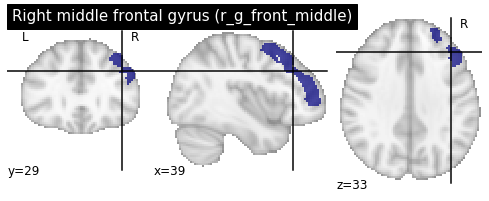

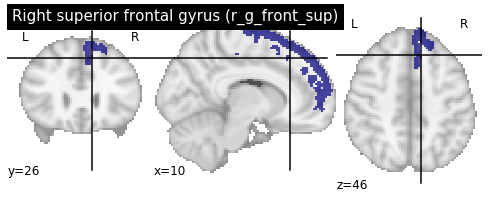

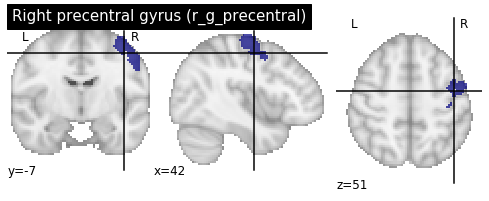

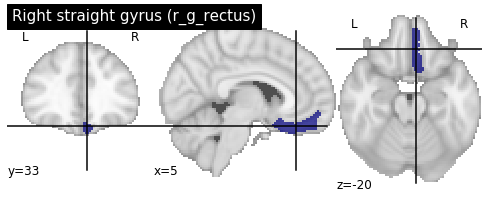

In [22]:
with nl.environment as e:
    res = nl.query(
        (e.z, e.w, e.region_1),
        e.rdf_schema_label(e.x, 'Right frontal lobe') &
        e['fma3.0_regional_part_of'](e.y, e.x) &
        e.rdf_schema_label(e.y, e.z) &
        e.relations(e.w, e.z) &
        e.destrieux_regions(e.w, e.region_1)
    )

for ontology_name, desikan_name, region in res:
    plotting.plot_roi(region.spatial_image(), title=f'{ontology_name} ({desikan_name})')

Or we can use Neurosynth to obtain all the regions related with the term 'auditory' and use the ontology to get the ones that are related with an specific region (In this case, the temporal lobe).

In [7]:
q = 0.0001
neurosynth_auditory = nl.load_neurosynth_term_regions(
    'auditory',
    name='neurosynth_auditory',
    q=q,
)

association-test_z_FDR_0.0001 0.0001


/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:435: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/frontend/neurosynth_data/dataset.pkl'>
  dataset = pickle.load(open(filename, 'rb'))
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retv

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


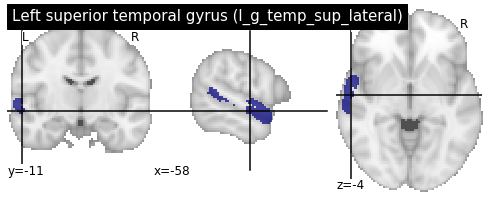

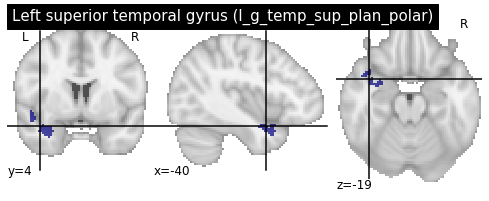

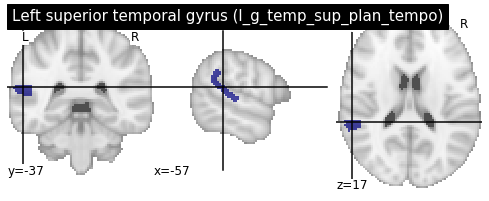

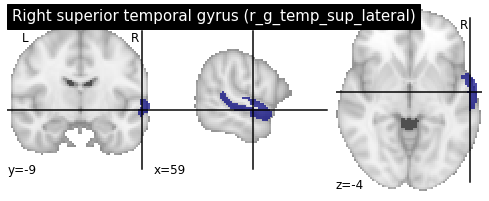

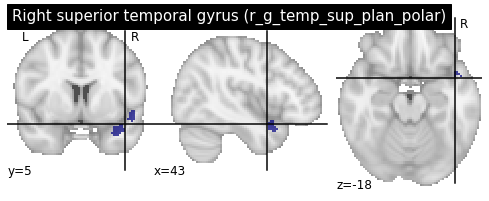

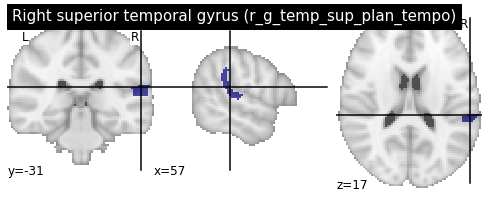

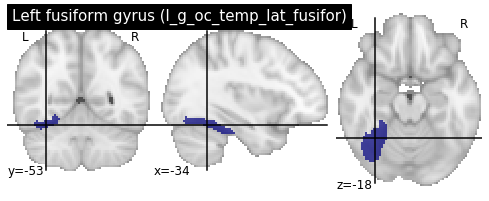

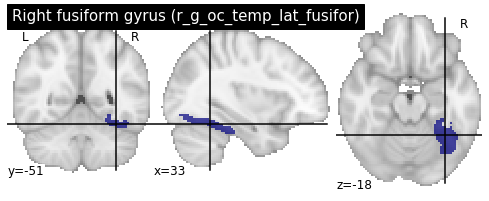

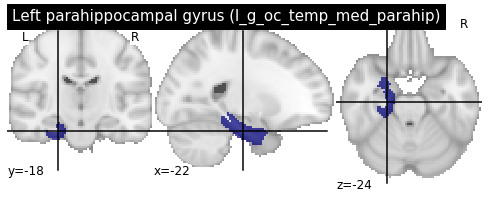

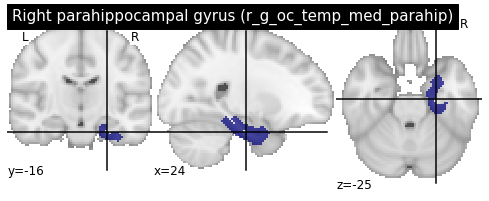

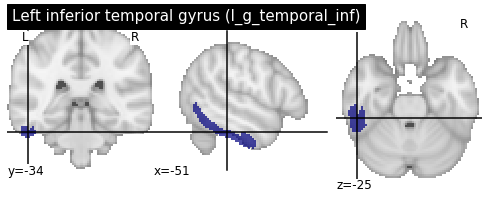

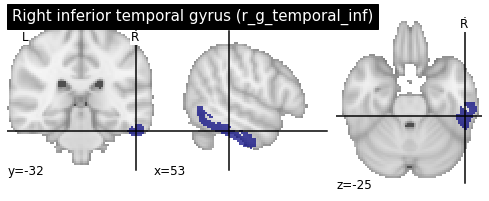

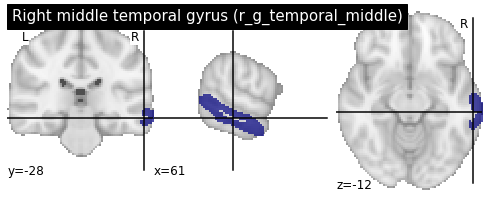

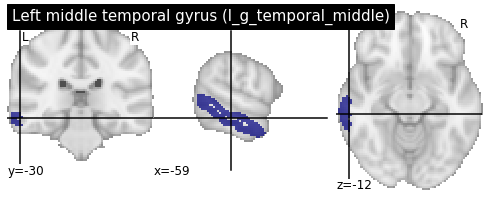

In [11]:
with nl.environment as e:
    res = nl.query(
        (e.v, e.w, e.region_1, e.region_2),
        e.rdf_schema_label(e.x, 'Temporal lobe') &
        e['fma3.0_regional_part_of'](e.z, e.x) &
        e.rdf_schema_subClassOf(e.y, e.z) &
        e.rdf_schema_label(e.y, e.v) &
        e.relations(e.w, e.v) &
        e.destrieux_regions(e.w, e.region_1) & e.neurosynth_auditory(e.region_2) &
        (e.region_volume(e.region_2) > 1500) &
        nl.symbols.overlapping(e.region_1, e.region_2)
    )
    
for ontology_name, desikan_name, region1, region2 in res:
    plotting.plot_roi(region1.spatial_image(), title=f'{ontology_name} ({desikan_name})')

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


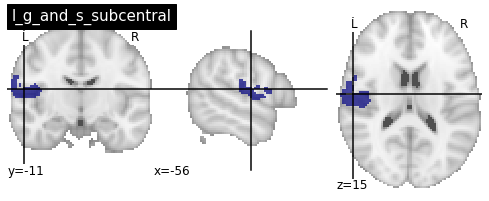

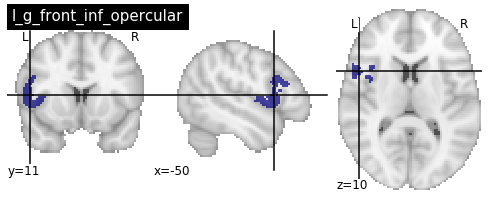

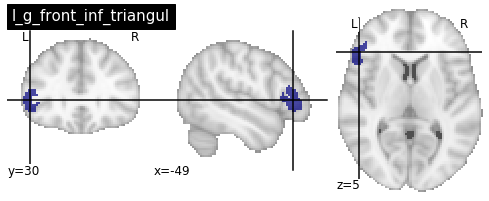

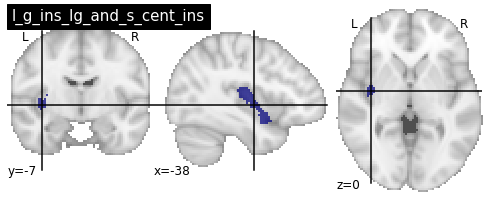

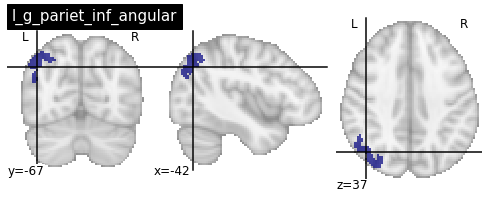

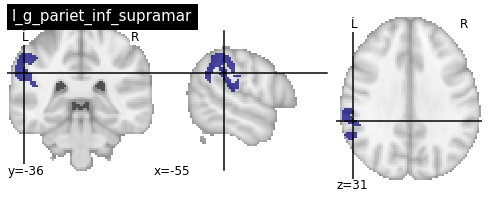

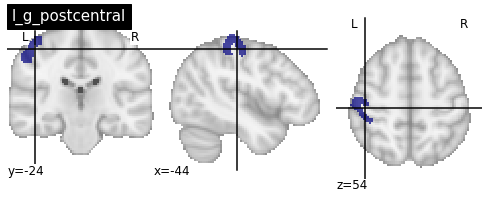

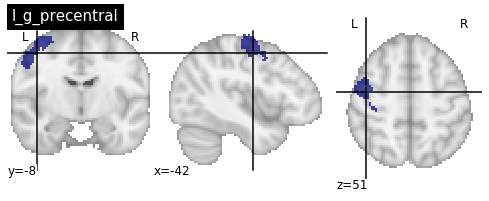

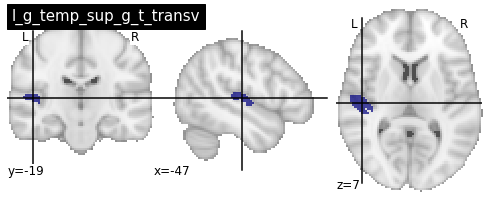

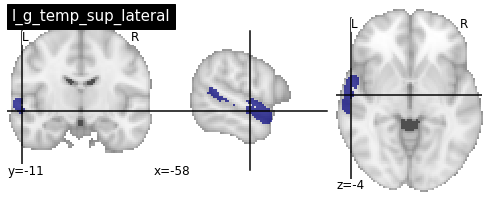

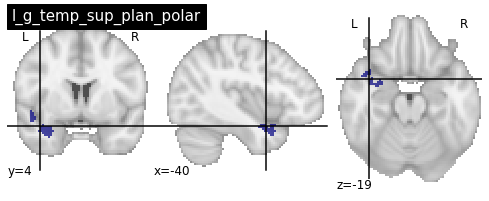

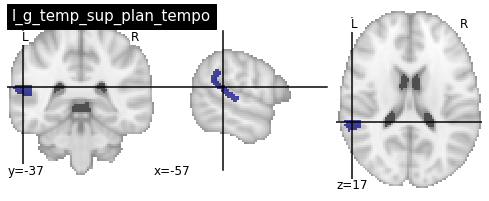

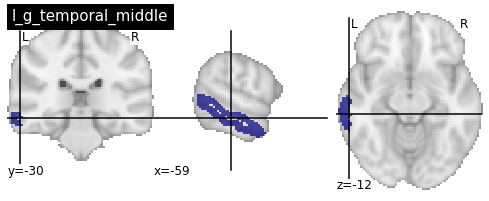

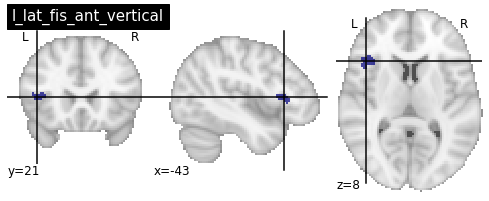

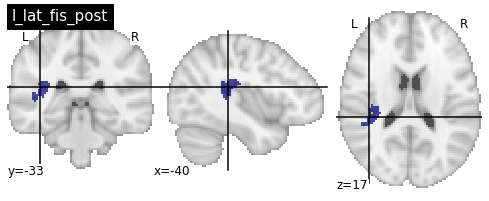

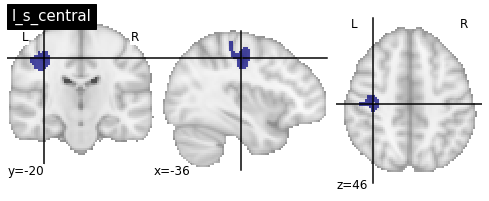

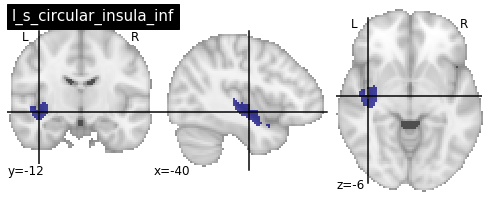

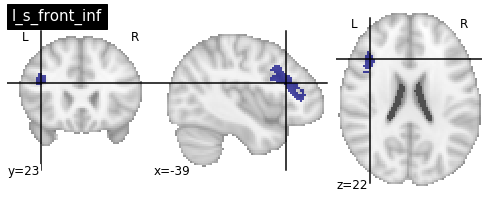

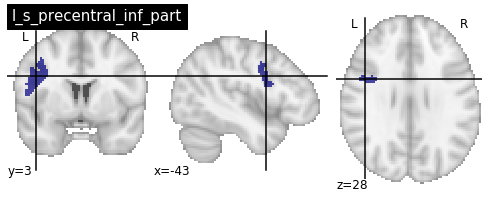

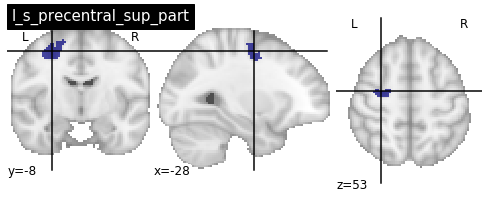

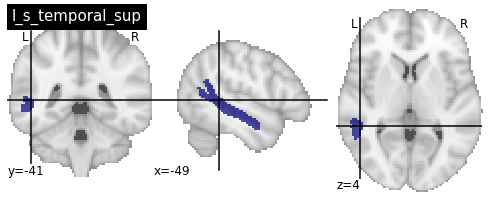

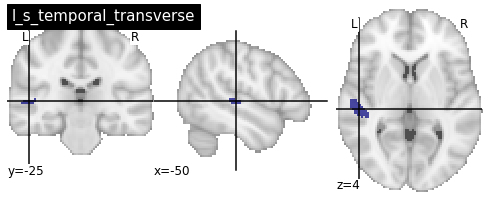

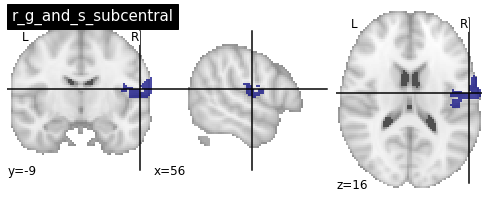

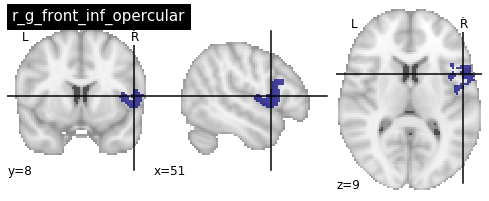

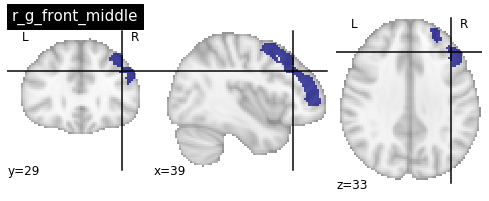

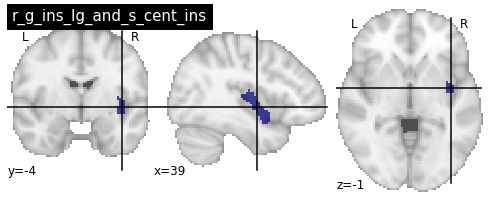

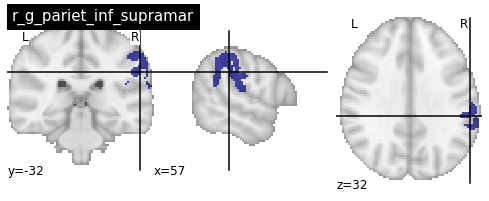

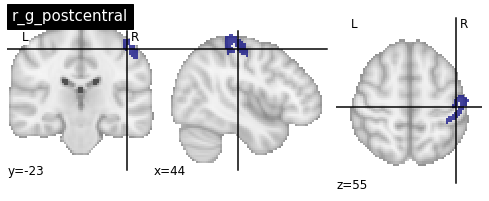

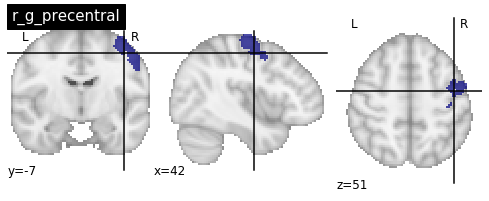

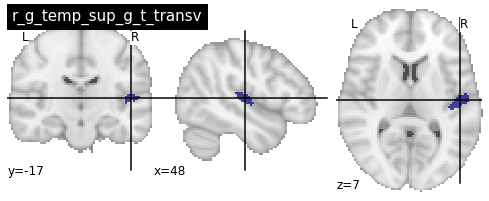

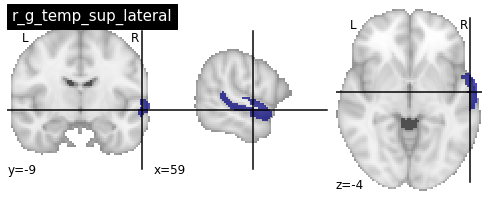

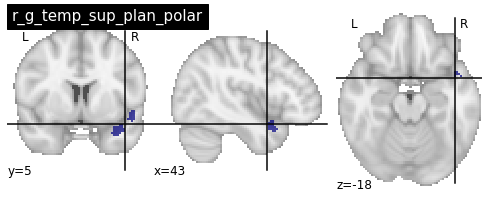

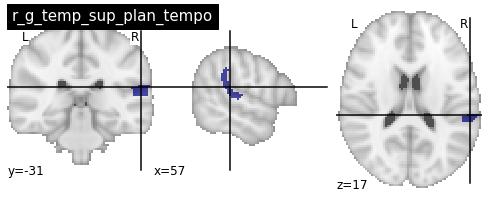

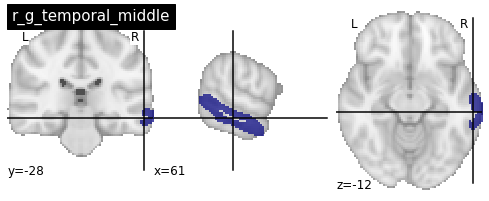

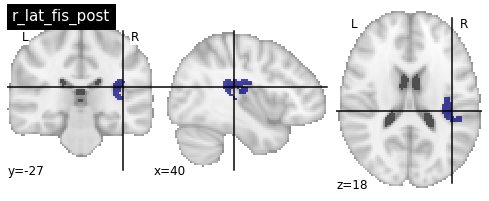

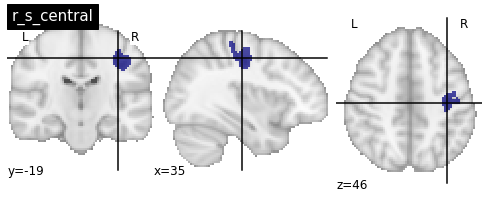

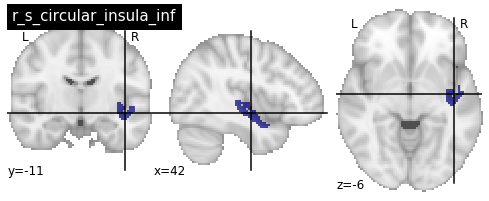

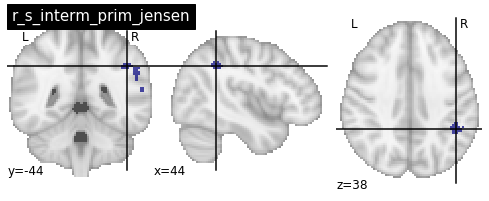

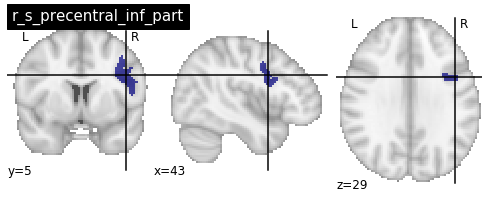

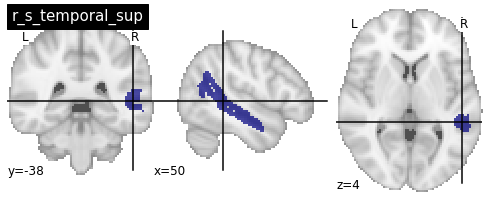

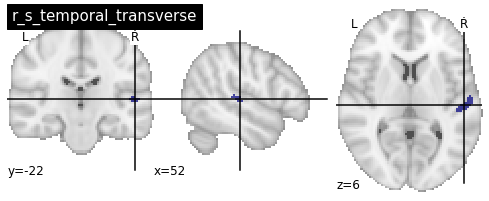

In [73]:
with nl.environment as e:
    res = nl.query(
        (e.w, e.region_1),
        e.destrieux_regions(e.w, e.region_1) & e.neurosynth_auditory(e.region_2) &
        (e.region_volume(e.region_2) > 1500) &
        nl.symbols.overlapping(e.region_1, e.region_2)
    )
    
for name, region in res:
    plotting.plot_roi(region.spatial_image(), title=name)

As you can see, only the superior and middle temporal gyrus are captured, while the same query without the ontology returns regions, such as the postcentral gyro, which should not be present.

## More use cases will be added shortly.

# Visual word

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  container.sort_index(axis=1, inplace=True)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  container.sort_index(axis=1, inplace=True)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  co

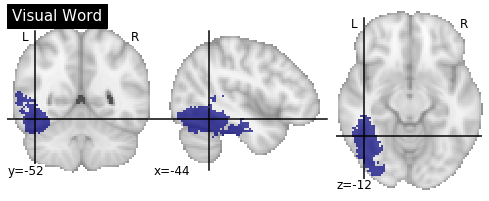

In [66]:
#You can use these one to try

with nl.scope as e:
    e.regional_part[e.x, e.w] = (
        e.rdf_schema_subClassOf(e.y, e.x) &
        e.rdf_schema_label(e.y, e.v) &
        e.relations(e.w, e.v)
    )
    
    e.temporal_union[e.region_union(e.region_2)] = (
        e.rdf_schema_label(e.x, 'Fusiform gyrus') &
        e.regional_part(e.x, e.w) &
        e.destrieux_regions(e.w, e.region_1) &
        e.neurosynth_vword(e.region_2) &
        (e.region_volume(e.region_2) > 1500) &
        nl.symbols.overlapping(e.region_1, e.region_2)
    )
    
    res = nl.query(
        (e.region,),
        e.temporal_union(e.region)
    )
    
    for region in res:
        plotting.plot_roi(region[0].spatial_image(), title='Visual Word')

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Wi

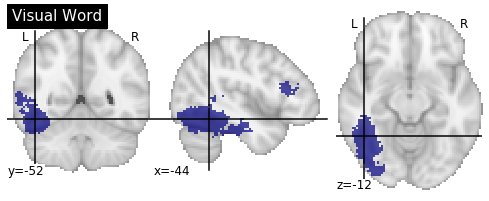

In [65]:
q = 0.001
neurosynth_vword = nl.load_neurosynth_term_regions(
    'visual word',
    name='neurosynth_vword',
    q=q,
)

with nl.scope as e:
    e.temporal_union[region_union(e.region)] = (
        e.neurosynth_vword(e.region) &
        (e.region_volume(e.region) > 1500)
    )
    
    res2 = nl.query(
        (e.region,),
        e.temporal_union(e.region)
    )
        
    for region in res2:
        plotting.plot_roi(region[0].spatial_image(), title='Visual Word')

# Auditory

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Wi

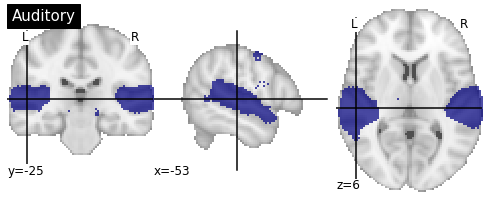

In [73]:
q = 0.0001
neurosynth_auditory = nl.load_neurosynth_term_regions(
    'auditory',
    name='neurosynth_auditory',
    q=q,
)

with nl.scope as e:
    e.temporal_union[region_union(e.region)] = (
        e.neurosynth_auditory(e.region) &
        (e.region_volume(e.region) > 0)
    )
    
    res2 = nl.query(
        (e.region,),
        e.temporal_union(e.region)
    )
        
    for region in res2:
        plotting.plot_roi(region[0].spatial_image(), title='Auditory')

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  container.sort_index(axis=1, inplace=True)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  container.sort_index(axis=1, inplace=True)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py

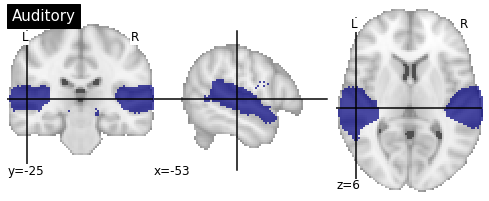

In [76]:
with nl.scope as e:
    e.regional_part[e.x, e.w] = (
        e['fma3.0_regional_part_of'](e.z, e.x) &
        e.rdf_schema_subClassOf(e.y, e.z) &
        e.rdf_schema_label(e.y, e.v) &
        e.relations(e.w, e.v)
    )
    
    #e.overlapping_destrieux_neurosynth[e.w, e.region_2] = (
    #    e.destrieux_regions(e.w, e.region_1) &
    #    e.neurosynth_auditory(e.region_2) &
    #    (e.region_volume(e.region_2) > 0) &
    #    nl.symbols.overlapping(e.region_1, e.region_2)
    #)
    
    e.temporal_union[e.region_union(e.region_2)] = (
        e.rdf_schema_label(e.x, 'Temporal lobe') &
        e.regional_part(e.x, e.w) &
        e.destrieux_regions(e.w, e.region_1) &
        e.neurosynth_auditory(e.region_2) &
        (e.region_volume(e.region_2) > 0) &
        nl.symbols.overlapping(e.region_1, e.region_2)
    )
    
    res = nl.query(
        (e.region,),
        e.temporal_union(e.region)
    )
    
    for region in res:
        plotting.plot_roi(region[0].spatial_image(), title='Auditory')

# Finger tapping

/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/dataset.py:716: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  feature_weights = self.data.ix[:, features]
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/pandas/core/indexing.py:888: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  retval = getattr(retval, self.name)._getitem_axis(key, axis=i)
/Users/gzanitti/miniconda3/envs/neurolang/lib/python3.7/site-packages/neurosynth/base/mask.py:232: DeprecationWarning: get_header method is deprecated.
Please use the ``img.header`` property instead.

* deprecated from version: 2.1
* Wi

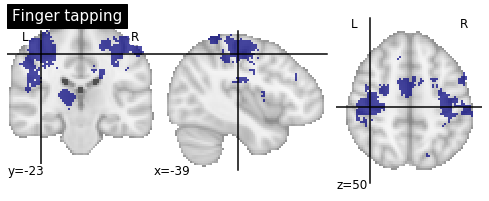

In [57]:
q = 0.01
neurosynth_ftapping = nl.load_neurosynth_term_regions(
    'finger tapping',
    name='neurosynth_ftapping',
    q=q,
)

with nl.scope as e:
    e.temporal_union[region_union(e.region)] = (
        e.neurosynth_ftapping(e.region) &
        (e.region_volume(e.region) > 0)
    )
    
    res2 = nl.query(
        (e.region,),
        e.temporal_union(e.region)
    )
        
    for region in res2:
        plotting.plot_roi(region[0].spatial_image(), title='Finger tapping')

In [72]:
with nl.scope as e:
    e.synonyms[e.x, e.z] = (
        e['fma3.0_Synonym'](e.x, e.y) &
        e['fma3.0_name'](e.y, e.z)
    )
    
    e.regional_part[e.x, e.w] = (
        e['fma3.0_regional_part_of'](e.z, e.x) &
        e.rdf_schema_subClassOf(e.y, e.z) &
        e.rdf_schema_label(e.y, e.v) &
        e.relations(e.w, e.v)
    )
    
    #e.overlapping_destrieux_neurosynth[e.w, e.region_2] = (
    #    e.destrieux_regions(e.w, e.region_1) &
    #    e.neurosynth_ftapping(e.region_2) &
    #    (e.region_volume(e.region_2) > 0) &
    #    nl.symbols.overlapping(e.region_1, e.region_2)
    #    (e.region_3 == e.region_intersection(e.region_1, e.region_2))
    #)
    
    e.union[e.region_union(e.region_3)] = (
        e.synonyms(e.x, 'Precentral convolution') &
        e.regional_part(e.x, e.w) &
        e.destrieux_regions(e.w, e.region_1) &
        e.neurosynth_ftapping(e.region_2) &
        (e.region_volume(e.region_2) > 0) &
        #nl.symbols.overlapping(e.region_1, e.region_2) &
        (e.region_3 == e.region_intersection(e.region_1, e.region_2))
    )
    
    
    res = nl.query(
        (e.region,),
        e.union(e.region)
    )
    
    for region in res:
        plotting.plot_roi(region[0].spatial_image(), title='Finger tapping')

/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/datalog/aggregation.py:131: UserWarning: No check performed. Should implement check for stratified aggregation
  "No check performed. Should implement check for stratified"
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  container.sort_index(axis=1, inplace=True)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py:380: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  container.sort_index(axis=1, inplace=True)
/Users/gzanitti/Projects/INRIA/NeuroLang/neurolang/utils/relational_algebra_set.py

KeyboardInterrupt: 

# Cognitive control